In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)
print(f"Using device: {device}")
print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")


Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce RTX 4070 SUPER


Epoch [1/20], Train Loss: 1.6175, Val Loss: 1.3036, Val Accuracy: 0.5200
Epoch [2/20], Train Loss: 1.1572, Val Loss: 1.0076, Val Accuracy: 0.6481
Epoch [3/20], Train Loss: 0.9226, Val Loss: 0.9108, Val Accuracy: 0.6855
Epoch [4/20], Train Loss: 0.7687, Val Loss: 0.8205, Val Accuracy: 0.7239
Epoch [5/20], Train Loss: 0.6405, Val Loss: 0.8493, Val Accuracy: 0.7166
Epoch [6/20], Train Loss: 0.5278, Val Loss: 0.8325, Val Accuracy: 0.7330
Epoch [7/20], Train Loss: 0.4219, Val Loss: 0.8854, Val Accuracy: 0.7325
Epoch [8/20], Train Loss: 0.3429, Val Loss: 0.9932, Val Accuracy: 0.7206
Epoch [9/20], Train Loss: 0.2671, Val Loss: 1.0322, Val Accuracy: 0.7345
Epoch [10/20], Train Loss: 0.2212, Val Loss: 1.1270, Val Accuracy: 0.7370
Epoch [11/20], Train Loss: 0.1823, Val Loss: 1.2983, Val Accuracy: 0.7341
Epoch [12/20], Train Loss: 0.1613, Val Loss: 1.3848, Val Accuracy: 0.7227
Epoch [13/20], Train Loss: 0.1538, Val Loss: 1.4185, Val Accuracy: 0.7268
Epoch [14/20], Train Loss: 0.1360, Val Loss: 1.

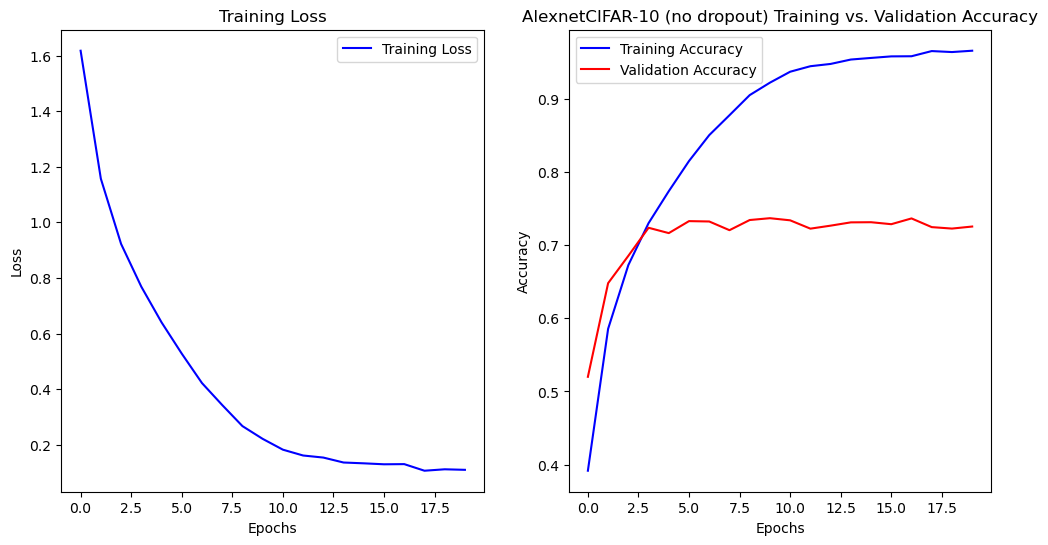


Final Test Accuracy: 0.7256
Precision: 0.7280
Recall: 0.7256
F1 Score: 0.7256


In [6]:
# Problem 1: Simplified Alexnet model CIFAR-10 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  # Resize to match CIFAR-10 (already 32x32)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  
            nn.ReLU(),
            
            nn.Linear(4096, 4096),
            nn.ReLU(),
           
            nn.Linear(4096, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function with validation loss tracking
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []  
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time


# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-10 (no dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.5644, Val Loss: 1.2202, Val Accuracy: 0.5521
Epoch [2/20], Train Loss: 1.1108, Val Loss: 1.0075, Val Accuracy: 0.6447
Epoch [3/20], Train Loss: 0.9251, Val Loss: 0.8976, Val Accuracy: 0.6841
Epoch [4/20], Train Loss: 0.7994, Val Loss: 0.8723, Val Accuracy: 0.7039
Epoch [5/20], Train Loss: 0.7006, Val Loss: 0.7955, Val Accuracy: 0.7284
Epoch [6/20], Train Loss: 0.6358, Val Loss: 0.7776, Val Accuracy: 0.7416
Epoch [7/20], Train Loss: 0.5778, Val Loss: 0.8053, Val Accuracy: 0.7328
Epoch [8/20], Train Loss: 0.5297, Val Loss: 0.7989, Val Accuracy: 0.7418
Epoch [9/20], Train Loss: 0.4833, Val Loss: 0.7963, Val Accuracy: 0.7476
Epoch [10/20], Train Loss: 0.4437, Val Loss: 0.8371, Val Accuracy: 0.7472
Epoch [11/20], Train Loss: 0.4096, Val Loss: 0.8488, Val Accuracy: 0.7464
Epoch [12/20], Train Loss: 0.3793, Val Loss: 0.8500, Val Accuracy: 0.7462
Epoch [13/20], Train Loss: 0.3768, Val Loss: 0.8161, Val Accuracy: 0.7487
Epoch [14/20], Train Loss: 0.3447, Val Loss: 0.

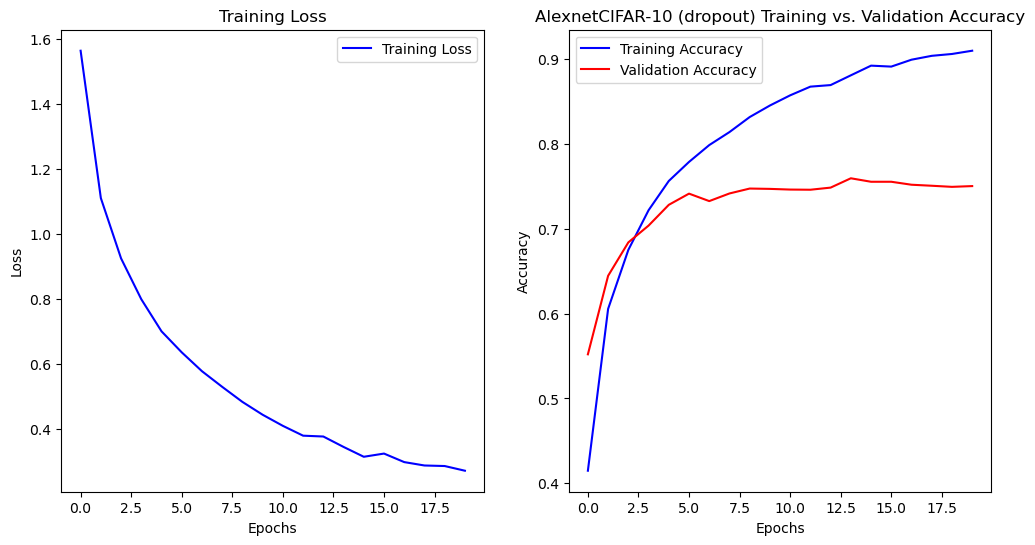


Final Test Accuracy: 0.7505
Precision: 0.7532
Recall: 0.7505
F1 Score: 0.7510


In [7]:
# Problem 1: Simplified Alexnet model CIFAR-10 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-10 (dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.0311, Val Loss: 3.5857, Val Accuracy: 0.1389
Epoch [2/20], Train Loss: 3.3490, Val Loss: 3.1291, Val Accuracy: 0.2261
Epoch [3/20], Train Loss: 2.9119, Val Loss: 2.8320, Val Accuracy: 0.2838
Epoch [4/20], Train Loss: 2.5714, Val Loss: 2.7319, Val Accuracy: 0.3187
Epoch [5/20], Train Loss: 2.2690, Val Loss: 2.5605, Val Accuracy: 0.3568
Epoch [6/20], Train Loss: 1.9577, Val Loss: 2.5465, Val Accuracy: 0.3668
Epoch [7/20], Train Loss: 1.6471, Val Loss: 2.6762, Val Accuracy: 0.3705
Epoch [8/20], Train Loss: 1.3138, Val Loss: 2.8483, Val Accuracy: 0.3723
Epoch [9/20], Train Loss: 1.0044, Val Loss: 3.3324, Val Accuracy: 0.3616
Epoch [10/20], Train Loss: 0.7265, Val Loss: 3.6967, Val Accuracy: 0.3735
Epoch [11/20], Train Loss: 0.5594, Val Loss: 4.2781, Val Accuracy: 0.3546
Epoch [12/20], Train Loss: 0.4462, Val Loss: 4.6897, Val Accuracy: 0.3542
Epoch [13/20], Train Loss: 0.3985, Val Loss: 4.9790, Val Accuracy: 0.3541
Epoch [14/20], Train Loss: 0.3403, Val Loss: 5.

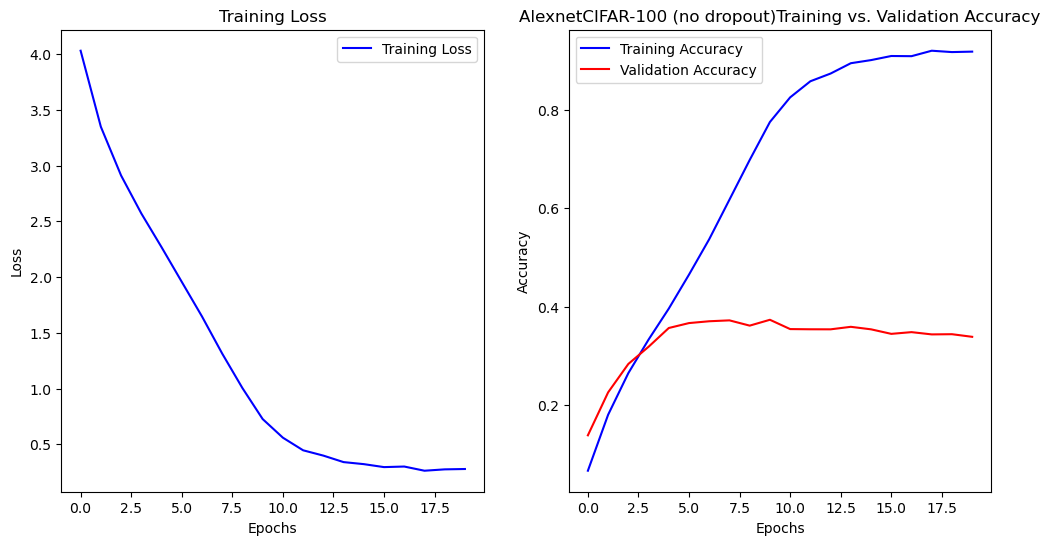


Final Test Accuracy: 0.3389
Precision: 0.3534
Recall: 0.3389
F1 Score: 0.3408


In [8]:
# Problem 1: Simplified Alexnet model CIFAR-100 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)



print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-100 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.1352, Val Loss: 3.7152, Val Accuracy: 0.1154
Epoch [2/20], Train Loss: 3.5357, Val Loss: 3.2457, Val Accuracy: 0.2110
Epoch [3/20], Train Loss: 3.1909, Val Loss: 3.0128, Val Accuracy: 0.2573
Epoch [4/20], Train Loss: 2.9504, Val Loss: 2.9047, Val Accuracy: 0.2785
Epoch [5/20], Train Loss: 2.7744, Val Loss: 2.7593, Val Accuracy: 0.3063
Epoch [6/20], Train Loss: 2.6212, Val Loss: 2.6801, Val Accuracy: 0.3261
Epoch [7/20], Train Loss: 2.4873, Val Loss: 2.5720, Val Accuracy: 0.3523
Epoch [8/20], Train Loss: 2.3679, Val Loss: 2.5781, Val Accuracy: 0.3478
Epoch [9/20], Train Loss: 2.2521, Val Loss: 2.5086, Val Accuracy: 0.3658
Epoch [10/20], Train Loss: 2.1587, Val Loss: 2.5390, Val Accuracy: 0.3604
Epoch [11/20], Train Loss: 2.0477, Val Loss: 2.5115, Val Accuracy: 0.3718
Epoch [12/20], Train Loss: 1.9551, Val Loss: 2.5179, Val Accuracy: 0.3659
Epoch [13/20], Train Loss: 1.8612, Val Loss: 2.5198, Val Accuracy: 0.3706
Epoch [14/20], Train Loss: 1.7784, Val Loss: 2.

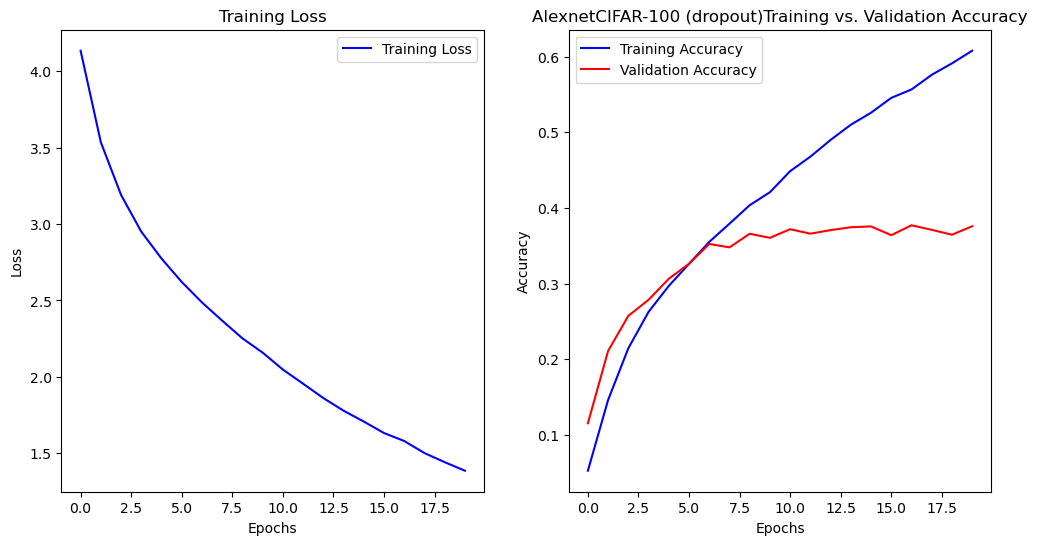


Final Test Accuracy: 0.3757
Precision: 0.3837
Recall: 0.3757
F1 Score: 0.3722


In [9]:
# Problem 1: Simplified Alexnet model CIFAR-100 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for CIFAR-10 image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output layer for CIFAR-10
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-100 (dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.5960, Val Loss: 1.3005, Val Accuracy: 0.5380
Epoch [2/20], Train Loss: 1.0450, Val Loss: 0.9434, Val Accuracy: 0.6747
Epoch [3/20], Train Loss: 0.7998, Val Loss: 0.8742, Val Accuracy: 0.7085
Epoch [4/20], Train Loss: 0.6489, Val Loss: 0.7888, Val Accuracy: 0.7376
Epoch [5/20], Train Loss: 0.5159, Val Loss: 0.7868, Val Accuracy: 0.7464
Epoch [6/20], Train Loss: 0.4063, Val Loss: 0.8376, Val Accuracy: 0.7433
Epoch [7/20], Train Loss: 0.3065, Val Loss: 0.9393, Val Accuracy: 0.7427
Epoch [8/20], Train Loss: 0.2324, Val Loss: 1.0135, Val Accuracy: 0.7475
Epoch [9/20], Train Loss: 0.1843, Val Loss: 1.1738, Val Accuracy: 0.7438
Epoch [10/20], Train Loss: 0.1503, Val Loss: 1.3370, Val Accuracy: 0.7419
Epoch [11/20], Train Loss: 0.1398, Val Loss: 1.3836, Val Accuracy: 0.7334
Epoch [12/20], Train Loss: 0.1303, Val Loss: 1.3720, Val Accuracy: 0.7361
Epoch [13/20], Train Loss: 0.1124, Val Loss: 1.4589, Val Accuracy: 0.7325
Epoch [14/20], Train Loss: 0.1060, Val Loss: 1.

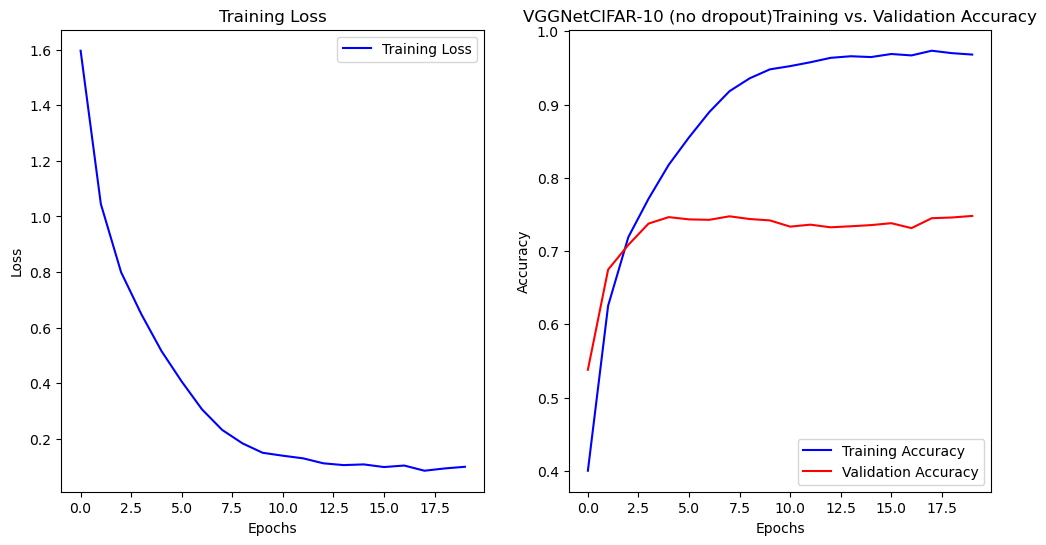


Final Test Accuracy: 0.7480
Precision: 0.7468
Recall: 0.7480
F1 Score: 0.7462


In [10]:
# Problem 2: Simplified VGGnet model CIFAR-10 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-10 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.5754, Val Loss: 1.1763, Val Accuracy: 0.5666
Epoch [2/20], Train Loss: 1.0490, Val Loss: 0.9475, Val Accuracy: 0.6761
Epoch [3/20], Train Loss: 0.8419, Val Loss: 0.8821, Val Accuracy: 0.7030
Epoch [4/20], Train Loss: 0.7190, Val Loss: 0.7334, Val Accuracy: 0.7439
Epoch [5/20], Train Loss: 0.6219, Val Loss: 0.7517, Val Accuracy: 0.7520
Epoch [6/20], Train Loss: 0.5621, Val Loss: 0.7414, Val Accuracy: 0.7541
Epoch [7/20], Train Loss: 0.5045, Val Loss: 0.7085, Val Accuracy: 0.7718
Epoch [8/20], Train Loss: 0.4511, Val Loss: 0.7527, Val Accuracy: 0.7663
Epoch [9/20], Train Loss: 0.4183, Val Loss: 0.7620, Val Accuracy: 0.7679
Epoch [10/20], Train Loss: 0.3871, Val Loss: 0.7379, Val Accuracy: 0.7726
Epoch [11/20], Train Loss: 0.3533, Val Loss: 0.7644, Val Accuracy: 0.7691
Epoch [12/20], Train Loss: 0.3394, Val Loss: 0.8078, Val Accuracy: 0.7741
Epoch [13/20], Train Loss: 0.3264, Val Loss: 0.8346, Val Accuracy: 0.7715
Epoch [14/20], Train Loss: 0.3103, Val Loss: 0.

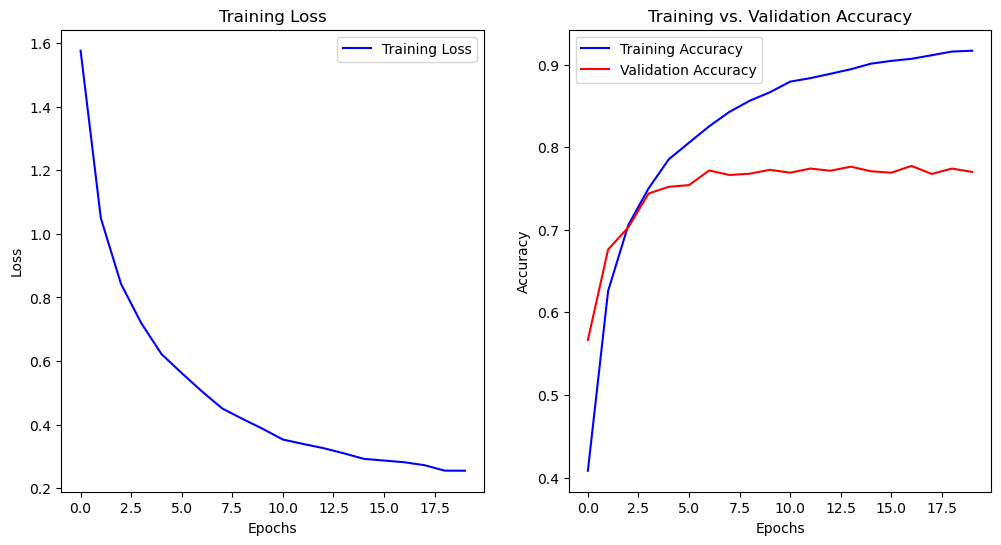


Final Test Accuracy: 0.7700
Precision: 0.7770
Recall: 0.7700
F1 Score: 0.7714


In [3]:
# Problem 2: Simplified VGGnet model CIFAR-10 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 3.9784, Val Loss: 3.5029, Val Accuracy: 0.1528
Epoch [2/20], Train Loss: 3.2974, Val Loss: 3.0605, Val Accuracy: 0.2473
Epoch [3/20], Train Loss: 2.8688, Val Loss: 2.7952, Val Accuracy: 0.3020
Epoch [4/20], Train Loss: 2.5154, Val Loss: 2.6223, Val Accuracy: 0.3369
Epoch [5/20], Train Loss: 2.1974, Val Loss: 2.5164, Val Accuracy: 0.3611
Epoch [6/20], Train Loss: 1.8722, Val Loss: 2.5111, Val Accuracy: 0.3752
Epoch [7/20], Train Loss: 1.5430, Val Loss: 2.6789, Val Accuracy: 0.3773
Epoch [8/20], Train Loss: 1.1909, Val Loss: 2.9515, Val Accuracy: 0.3797
Epoch [9/20], Train Loss: 0.8933, Val Loss: 3.2730, Val Accuracy: 0.3791
Epoch [10/20], Train Loss: 0.6522, Val Loss: 3.9272, Val Accuracy: 0.3623
Epoch [11/20], Train Loss: 0.5040, Val Loss: 4.1840, Val Accuracy: 0.3674
Epoch [12/20], Train Loss: 0.3946, Val Loss: 4.7279, Val Accuracy: 0.3614
Epoch [13/20], Train Loss: 0.3629, Val Loss: 5.1107, Val Accuracy: 0.3526
Epoch [14/20], Train Loss: 0.3153, Val Loss: 5.

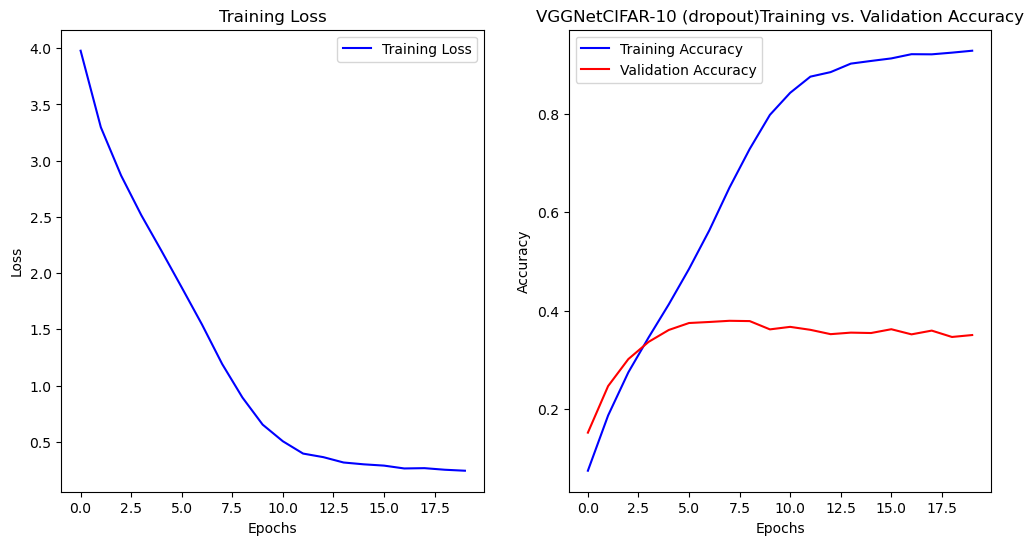


Final Test Accuracy: 0.3508
Precision: 0.3634
Recall: 0.3508
F1 Score: 0.3516


In [4]:
# Problem 2: Simplified VGGnet model CIFAR-100 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-10 (dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.1148, Val Loss: 3.6765, Val Accuracy: 0.1282
Epoch [2/20], Train Loss: 3.4737, Val Loss: 3.1931, Val Accuracy: 0.2178
Epoch [3/20], Train Loss: 3.1184, Val Loss: 2.9299, Val Accuracy: 0.2725
Epoch [4/20], Train Loss: 2.8650, Val Loss: 2.7393, Val Accuracy: 0.3105
Epoch [5/20], Train Loss: 2.6640, Val Loss: 2.6280, Val Accuracy: 0.3323
Epoch [6/20], Train Loss: 2.4854, Val Loss: 2.5714, Val Accuracy: 0.3476
Epoch [7/20], Train Loss: 2.3380, Val Loss: 2.4827, Val Accuracy: 0.3636
Epoch [8/20], Train Loss: 2.2021, Val Loss: 2.4384, Val Accuracy: 0.3792
Epoch [9/20], Train Loss: 2.0797, Val Loss: 2.4042, Val Accuracy: 0.3848
Epoch [10/20], Train Loss: 1.9626, Val Loss: 2.3657, Val Accuracy: 0.3976
Epoch [11/20], Train Loss: 1.8463, Val Loss: 2.3629, Val Accuracy: 0.4008
Epoch [12/20], Train Loss: 1.7548, Val Loss: 2.3634, Val Accuracy: 0.4050
Epoch [13/20], Train Loss: 1.6664, Val Loss: 2.3712, Val Accuracy: 0.4068
Epoch [14/20], Train Loss: 1.5796, Val Loss: 2.

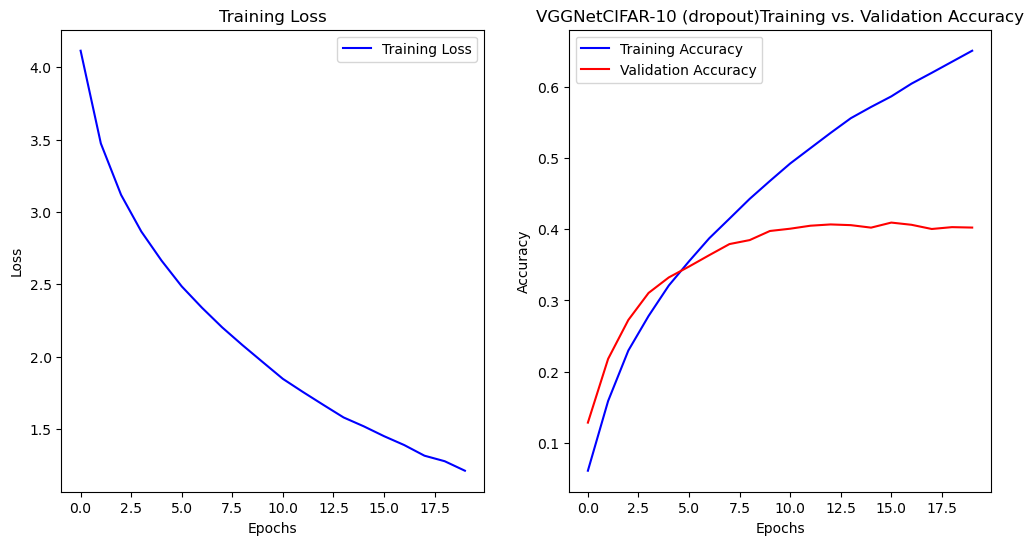


Final Test Accuracy: 0.4024
Precision: 0.4173
Recall: 0.4024
F1 Score: 0.4020


In [3]:
# Problem 2: Simplified VGGnet model CIFAR-100 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-10 (dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.3497, Val Loss: 1.0148, Val Accuracy: 0.6419
Epoch [2/20], Train Loss: 0.9528, Val Loss: 0.9649, Val Accuracy: 0.6658
Epoch [3/20], Train Loss: 0.7876, Val Loss: 0.8002, Val Accuracy: 0.7222
Epoch [4/20], Train Loss: 0.6705, Val Loss: 0.7652, Val Accuracy: 0.7372
Epoch [5/20], Train Loss: 0.5628, Val Loss: 0.7163, Val Accuracy: 0.7597
Epoch [6/20], Train Loss: 0.4804, Val Loss: 0.7404, Val Accuracy: 0.7532
Epoch [7/20], Train Loss: 0.4022, Val Loss: 0.7452, Val Accuracy: 0.7585
Epoch [8/20], Train Loss: 0.3327, Val Loss: 0.7844, Val Accuracy: 0.7630
Epoch [9/20], Train Loss: 0.2583, Val Loss: 0.7857, Val Accuracy: 0.7757
Epoch [10/20], Train Loss: 0.2036, Val Loss: 0.8294, Val Accuracy: 0.7715
Epoch [11/20], Train Loss: 0.1711, Val Loss: 0.9644, Val Accuracy: 0.7682
Epoch [12/20], Train Loss: 0.1405, Val Loss: 0.9688, Val Accuracy: 0.7701
Epoch [13/20], Train Loss: 0.1197, Val Loss: 0.9975, Val Accuracy: 0.7708
Epoch [14/20], Train Loss: 0.1060, Val Loss: 1.

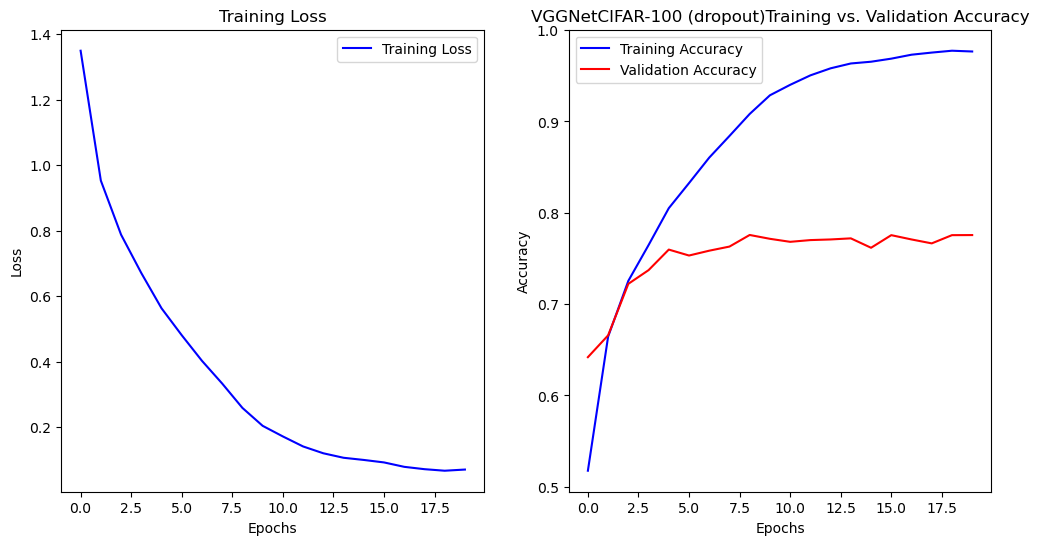


Final Test Accuracy: 0.7756
Precision: 0.7770
Recall: 0.7756
F1 Score: 0.7757


In [4]:
# Problem 3: Simplified VGGnet model CIFAR-10 without Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Resnet Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

# ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-100 (dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Train Loss: 1.8514, Val Loss: 1.5043, Val Accuracy: 0.4482
Epoch [2/20], Train Loss: 1.4664, Val Loss: 1.3019, Val Accuracy: 0.5505
Epoch [3/20], Train Loss: 1.3042, Val Loss: 1.1002, Val Accuracy: 0.6101
Epoch [4/20], Train Loss: 1.1937, Val Loss: 1.0167, Val Accuracy: 0.6434
Epoch [5/20], Train Loss: 1.1124, Val Loss: 0.9160, Val Accuracy: 0.6743
Epoch [6/20], Train Loss: 1.0490, Val Loss: 0.8671, Val Accuracy: 0.6980
Epoch [7/20], Train Loss: 1.0142, Val Loss: 0.8613, Val Accuracy: 0.7034
Epoch [8/20], Train Loss: 0.9723, Val Loss: 0.8026, Val Accuracy: 0.7237
Epoch [9/20], Train Loss: 0.9321, Val Loss: 0.7795, Val Accuracy: 0.7297
Epoch [10/20], Train Loss: 0.9073, Val Loss: 0.7907, Val Accuracy: 0.7274
Epoch [11/20], Train Loss: 0.8812, Val Loss: 0.7247, Val Accuracy: 0.7487
Epoch [12/20], Train Loss: 0.8534, Val Loss: 0.7260, Val Accuracy: 0.7486
Epoch [13/20], Train Loss: 0.8439, Val Loss: 0.7062, Val Accuracy: 0.7550
Epoch [14/20], Train Loss: 0.8210, Val Loss: 0.

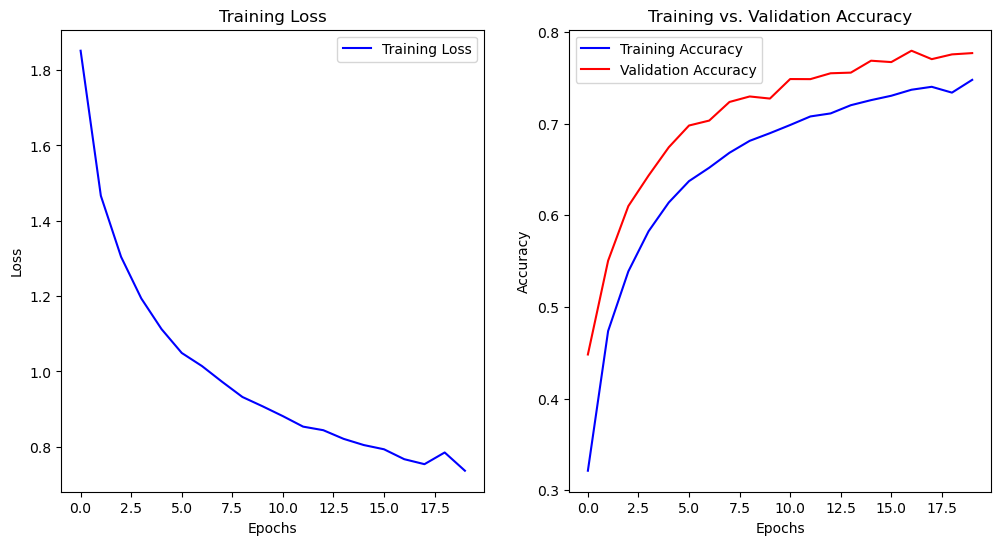


Final Test Accuracy: 0.7770
Precision: 0.7783
Recall: 0.7770
F1 Score: 0.7746


In [5]:
# Problem 3: Simplified Resnet-18 model CIFAR-10 with Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ResNet Block with Dropout
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, dropout_prob=0.3):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout_prob)  

        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)  

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        x = self.dropout2(x)  
        return x

# ResNet-18 Model with Dropout
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes, dropout_prob=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)  

        self.layer1 = self.__make_layer(64, 64, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self.__make_layer(64, 128, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.__make_layer(128, 256, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.__make_layer(256, 512, stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.fc_dropout = nn.Dropout(p=dropout_prob) 

    def __make_layer(self, in_channels, out_channels, stride, dropout_prob):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride, dropout_prob=dropout_prob),
            Block(out_channels, out_channels, dropout_prob=dropout_prob)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x) 

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_dropout(x) 
        x = self.fc(x)
        return x 

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Train Loss: 3.5476, Val Loss: 3.0757, Val Accuracy: 0.2420
Epoch [2/20], Train Loss: 2.7384, Val Loss: 2.7410, Val Accuracy: 0.3384
Epoch [3/20], Train Loss: 2.2997, Val Loss: 2.4706, Val Accuracy: 0.3756
Epoch [4/20], Train Loss: 1.9898, Val Loss: 2.1756, Val Accuracy: 0.4331
Epoch [5/20], Train Loss: 1.7159, Val Loss: 2.2063, Val Accuracy: 0.4487
Epoch [6/20], Train Loss: 1.4446, Val Loss: 2.1060, Val Accuracy: 0.4708
Epoch [7/20], Train Loss: 1.1717, Val Loss: 2.2228, Val Accuracy: 0.4601
Epoch [8/20], Train Loss: 0.8912, Val Loss: 2.2858, Val Accuracy: 0.4720
Epoch [9/20], Train Loss: 0.6545, Val Loss: 2.4289, Val Accuracy: 0.4800
Epoch [10/20], Train Loss: 0.4670, Val Loss: 2.7266, Val Accuracy: 0.4615
Epoch [11/20], Train Loss: 0.3578, Val Loss: 2.8546, Val Accuracy: 0.4643
Epoch [12/20], Train Loss: 0.2784, Val Loss: 3.0412, Val Accuracy: 0.4642
Epoch [13/20], Train Loss: 0.2509, Val Loss: 3.1715, Val Accuracy: 0.4574
Epoch [14/20], Train Loss: 0.2109, Val Loss: 3.

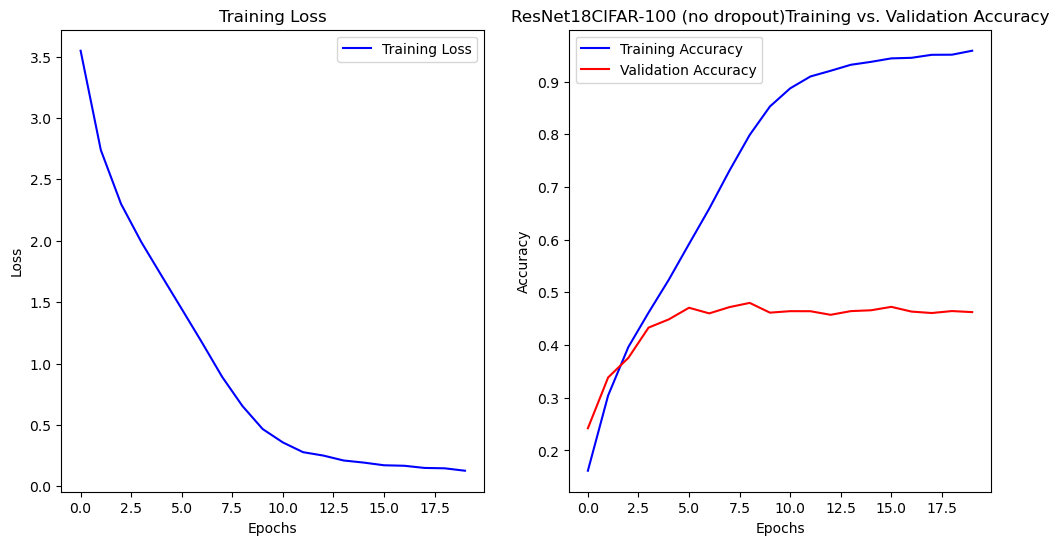


Final Test Accuracy: 0.4625
Precision: 0.4713
Recall: 0.4625
F1 Score: 0.4592


In [6]:
# Problem 3: Simplified VGGnet model CIFAR-100 without Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Resnet Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

# ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("ResNet18CIFAR-100 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Train Loss: 4.4417, Val Loss: 3.9969, Val Accuracy: 0.0724
Epoch [2/20], Train Loss: 3.9273, Val Loss: 3.6524, Val Accuracy: 0.1313
Epoch [3/20], Train Loss: 3.6294, Val Loss: 3.2384, Val Accuracy: 0.2094
Epoch [4/20], Train Loss: 3.4131, Val Loss: 3.0149, Val Accuracy: 0.2525
Epoch [5/20], Train Loss: 3.2487, Val Loss: 2.8635, Val Accuracy: 0.2767
Epoch [6/20], Train Loss: 3.1204, Val Loss: 2.7693, Val Accuracy: 0.3006
Epoch [7/20], Train Loss: 3.0348, Val Loss: 2.6990, Val Accuracy: 0.3080
Epoch [8/20], Train Loss: 2.9478, Val Loss: 2.6205, Val Accuracy: 0.3207
Epoch [9/20], Train Loss: 2.8837, Val Loss: 2.5794, Val Accuracy: 0.3319
Epoch [10/20], Train Loss: 2.8219, Val Loss: 2.5259, Val Accuracy: 0.3498
Epoch [11/20], Train Loss: 2.7641, Val Loss: 2.4167, Val Accuracy: 0.3622
Epoch [12/20], Train Loss: 2.7271, Val Loss: 2.4043, Val Accuracy: 0.3668
Epoch [13/20], Train Loss: 2.6782, Val Loss: 2.3946, Val Accuracy: 0.3721
Epoch [14/20], Train Loss: 2.6371, Val Loss: 2.

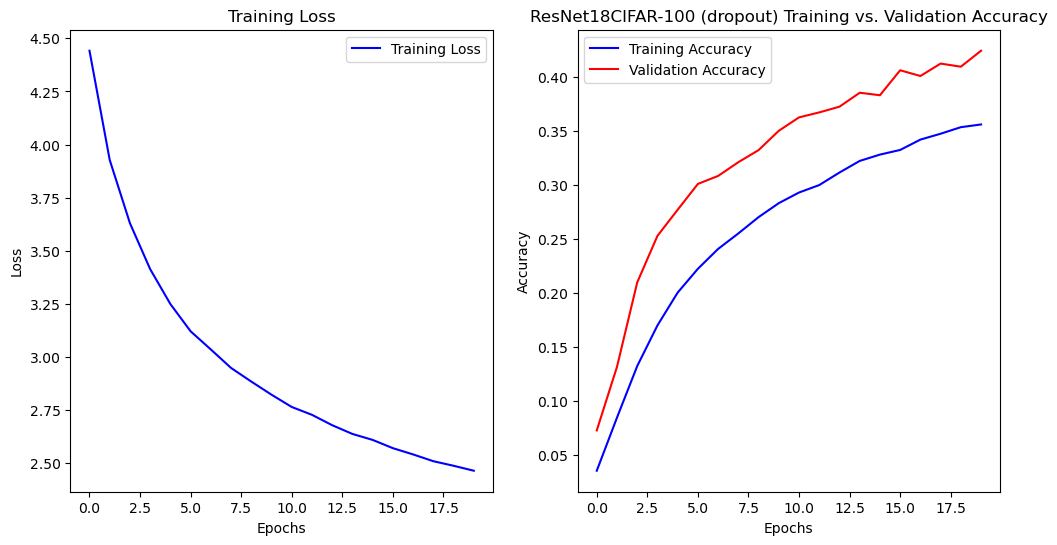


Final Test Accuracy: 0.4239


In [7]:
# Problem 3: Simplified Resnet-18 model CIFAR-100 with Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ResNet Block with Dropout
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, dropout_prob=0.3):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout_prob)  

        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)  

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        x = self.dropout2(x)  
        return x

# ResNet-18 Model with Dropout
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes, dropout_prob=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)  

        self.layer1 = self.__make_layer(64, 64, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self.__make_layer(64, 128, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.__make_layer(128, 256, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.__make_layer(256, 512, stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.fc_dropout = nn.Dropout(p=dropout_prob) 

    def __make_layer(self, in_channels, out_channels, stride, dropout_prob):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride, dropout_prob=dropout_prob),
            Block(out_channels, out_channels, dropout_prob=dropout_prob)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x) 

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_dropout(x) 
        x = self.fc(x)
        return x 

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("ResNet18CIFAR-100 (dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")